In [233]:
import numpy as np
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
env_names = ["cartpole", "minigrid-unlock"]
env_name = env_names[1]

# ppo only with cartpole available
algorithms = ["dqn", "ppo"]
algorithm = algorithms[0]

# how we tagged the record in tensorboard
tags = ["rollout/ep_rew_mean", "eval/mean_reward"]
tag = tags[1]

eval_or_rollout = tag.split("/")[0]

cartpole_starting_from_steps = 0#200_000 # set this to 200_000 to have a plot where our implementation was better

log_dir = f"../data/{algorithm}_logs/{env_name}/train"
reader = SummaryReader(log_dir, extra_columns={"dir_name"})
df = reader.scalars

df["ALG_ENV"] = df["dir_name"].apply(lambda x: "-".join(x.split("/")[1::]))
df

,step,tag,value,dir_name,ALG_ENV
0,2500,eval/mean_ep_length,288.000000,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
1,5000,eval/mean_ep_length,288.000000,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
2,7500,eval/mean_ep_length,288.000000,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
3,10000,eval/mean_ep_length,288.000000,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
4,12500,eval/mean_ep_length,288.000000,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
...,...,...,...,...,...
83441,497208,train/loss,0.000006,9/pretrain_combined/128/logs/DQN_1,pretrain_combined-128-logs-DQN_1
83442,497500,train/loss,0.000010,9/pretrain_combined/128/logs/DQN_1,pretrain_combined-128-logs-DQN_1
83443,498229,train/loss,0.000027,9/pretrain_combined/128/logs/DQN_1,pretrain_combined-128-logs-DQN_1
83444,499381,train/loss,0.000009,9/pretrain_combined/128/logs/DQN_1,pretrain_combined-128-logs-DQN_1


In [235]:
algs_envs = df["ALG_ENV"].unique()
algs_envs

array(['normal-128-logs-DQN_1', 'pretrain_combined-128-logs-DQN_1'],
      dtype=object)

In [236]:
def percentile_lower(x: pd.Series) -> pd.DataFrame:
    return np.percentile(x, 10)

def percentile_upper(x: pd.Series) -> pd.DataFrame:
    return np.percentile(x, 90)

df_pivot = df[df["tag"] == tag].pivot_table(
        index="step",
        columns="ALG_ENV",
        values="value",
        aggfunc=[np.median, percentile_lower, percentile_upper],
)
df_pivot.head()

/tmp/ipykernel_35462/1700267805.py:7: FutureWarning: The provided callable <function median at 0x7d06b2ba4360> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_pivot = df[df["tag"] == tag].pivot_table(


median                                   \
ALG_ENV normal-128-logs-DQN_1 pretrain_combined-128-logs-DQN_1   
step                                                             
2500                      0.0                              0.0   
5000                      0.0                              0.0   
7500                      0.0                              0.0   
10000                     0.0                              0.0   
12500                     0.0                              0.0   

             percentile_lower                                   \
ALG_ENV normal-128-logs-DQN_1 pretrain_combined-128-logs-DQN_1   
step                                                             
2500                      0.0                              0.0   
5000                      0.0                              0.0   
7500                      0.0                              0.0   
10000                     0.0                              0.0   
12500                     0.0                              0.0   

             percentile_upper                                   
ALG_ENV normal-128-logs-DQN_1 pretrain_combined-128-logs-DQN_1  
step                                                            
2500                      0.0                              0.0  
5000                      0.0                              0.0  
7500                      0.0                              0.0  
10000                     0.0                              0.0  
12500                     0.0                              0.0

In [237]:
if env_name == "minigrid-unlock" and False:
    # show starting from step 150_000
    df_pivot = df_pivot[df_pivot.index >= cartpole_starting_from_steps].copy()

    # make the columns to the cumulative sum
    # this doesnt make sense as the evaluation runs are separate from each other
    for col_name in df_pivot.columns:
        df_pivot[col_name] = df_pivot[col_name].cumsum()

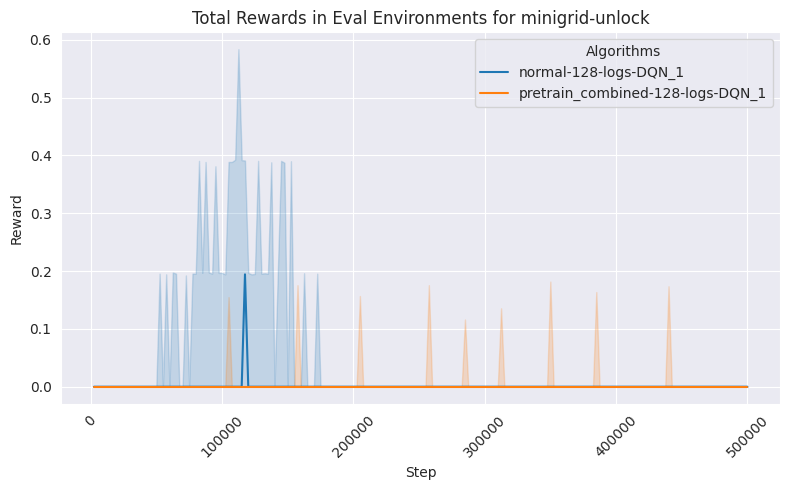

In [238]:
# Start plot
plt.figure(figsize=(8, 5))

# Get color palette
palette = sns.color_palette("tab10", len(algs_envs))

# Loop through each group
for i, group in enumerate(algs_envs):
    if group.find("qloss") != -1:
        continue

    # Plot line using seaborn
    sns.lineplot(x=df_pivot.index, y=df_pivot["median"][group], label=group, color=palette[i])

    # Add error bounds
    plt.fill_between(
        df_pivot.index,
        df_pivot["percentile_lower"][group],
        df_pivot["percentile_upper"][group],
        alpha=0.2,
        color=palette[i],
    )

# Final touches
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Total Rewards in {eval_or_rollout.title()} Environments for {env_name}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Algorithms")

plt.savefig(f"../{eval_or_rollout}_{algorithm}_{env_name}_out.png")